# Introduction

In [1]:
import spacy
from keras.preprocessing import text, sequence
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc

import numpy as np
import json
import zipfile as zip

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser

Using TensorFlow backend.


# Importing

Data is preprocessed as a list of lists, reviews are parsed and stop words and punctuation are removed.

In [3]:
with open('./processed/processed.txt', 'r') as f:
  restaurants = [json.loads(line) for line in f]

In [ ]:
sys.getsizeof(restaurants)/1024**2

In [44]:
# previous text cleaning method, removed too much
with open('./processed/reviews_old.txt', 'r') as f:
  reviews = [json.loads(line) for line in f]


In [10]:
# different text cleaning for reviews
with open('./processed/reviews_cleaned.txt', 'r') as f:
  reviews = [json.loads(line) for line in f]

## Keras text processing

In [2]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(['eat a lot, need to exercise more', "yeaaaaa", "who likes chicken all the time"])


In [3]:
tokenizer.word_index

{'a': 2,
 'all': 12,
 'chicken': 11,
 'eat': 1,
 'exercise': 6,
 'likes': 10,
 'lot': 3,
 'more': 7,
 'need': 4,
 'the': 13,
 'time': 14,
 'to': 5,
 'who': 9,
 'yeaaaaa': 8}

In [5]:
tokenizer.texts_to_sequences(['eat a lot, need to exercise more', "yeaaaaa"])

[[1, 2, 3, 4, 5, 6, 7], [8]]

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [6]:
# create dictionary
dict_yelp = corpora.Dictionary(reviews)

NameError: name 'reviews' is not defined

In [13]:
# re-rerun after filtering dictionary

corpus = [dict_yelp.doc2bow(review) for review in reviews]

In [33]:
# save corpus
corpora.MmCorpus.serialize('./processed/corpus.mm', corpus)

In [2]:
# load corpus
corpus = corpora.MmCorpus('./processed/corpus.mm')

In [110]:
dict_yelp.save('./processed/dictionary')

In [7]:
dict_yelp = corpora.Dictionary.load('./processed/dictionary')

In [29]:
len(dict_yelp.keys())

12578

In [154]:
sentiment(' '.join(reviews[300]))

[0.15971557682083998, 0.5728070175438597]

In [23]:
'good' in dict_yelp.values()

False

In [8]:
# tune corpus to get a smaller dictionary and doc_term matrix, embeddings will still work but bow will not fit into 8gb gpu memory otherwise
dict_yelp.filter_extremes(no_below=40, keep_n=20000)

In [11]:
??dict_yelp

In [20]:
dict_yelp[0]

'this'

In [42]:
top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
[(dict_yelp[item[0]], item[1]) for item in top_ids]

[('this', 240115),
 ('but', 234529),
 ('with', 212575),
 ('place', 204032),
 ('that', 201558),
 ('on', 194653),
 ('do', 176703),
 ('go', 167435),
 ('so', 159652),
 ('service', 155644),
 ('get', 152298),
 ('great', 151777),
 ('at', 146103),
 ('here', 139643),
 ('will', 131348),
 ('very', 126403),
 ('time', 124857),
 ('come', 122212),
 ('there', 121375),
 ('like', 119441),
 ('order', 117927),
 ('if', 115701),
 ('would', 115030),
 ('all', 113190),
 ('as', 112922),
 ('back', 110512),
 ('just', 109932),
 ('out', 109830),
 ('try', 102538),
 ('one', 101402)]

In [7]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_len = len(dictionary.keys()) + 2
    
    for word in text:        
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_len)
    
    return processed[0:max_len]        



In [9]:
text_sequencer(dict_yelp, reviews[50])

NameError: name 'reviews' is not defined

In [94]:
??sequence.pad_sequences

In [32]:
%%time

corpus = [text_sequencer(dict_yelp, review) for review in reviews]

CPU times: user 51.9 s, sys: 200 ms, total: 52.1 s
Wall time: 52.1 s


In [33]:
corpus = sequence.pad_sequences(corpus, maxlen=200)

In [15]:
# this is the converted corpus array, not from gensim
np.save('./processed/corpus.npy', corpus)

In [24]:
corpus = np.load('./processed/corpus.npy')

In [25]:
round(9 * .2)

2

In [16]:
corpus.shape

(490049, 200)

In [26]:
def data_split(data, proportion = .2):
    cutoff = round(len(data) * (1-proportion))
    return data[0:cutoff], data[cutoff:]
    

In [27]:
train,test = data_split(corpus)

In [28]:
train.shape

(392039, 200)

In [29]:
test.shape

(98010, 200)

## Integrating glove embeddings

In [30]:
emb_path = '/projects/embeddings/data/'

In [31]:
embeddings_index={}
with zip.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
    with f.open('glove.6B.100d.txt', 'r') as z:
        for line in z:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

In [32]:
def id_to_glove(keys, dict_yelp):
    
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
    return conversion_table

In [33]:
conversion_table = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)

In [34]:
embedding_matrix = np.vstack([conversion_table[key] for key in conversion_table.keys()])
embedding_matrix = np.vstack((np.zeros(100),embedding_matrix, np.random.randn(100)))

In [10]:
len(dict_yelp.keys())

12578

In [15]:
len(embedding_matrix)

12580

In [13]:
list(embeddings_index.keys())[0:10]

[b'the', b',', b'.', b'of', b'to', b'and', b'in', b'a', b'"', b"'s"]

In [45]:
dict_yelp[0]

'this'

In [ ]:
len(corpus)

In [35]:
len(dict_yelp.keys())

12578

In [47]:
490049*8*2000/1024**2

7477.5543212890625

In [33]:
del reviews

In [16]:
help(corpus2csc)

Help on function corpus2csc in module gensim.matutils:

corpus2csc(corpus, num_terms=None, dtype=<class 'numpy.float64'>, num_docs=None, num_nnz=None, printprogress=0)
    Convert a streamed corpus into a sparse matrix, in scipy.sparse.csc_matrix format,
    with documents as columns.
    
    If the number of terms, documents and non-zero elements is known, you can pass
    them here as parameters and a more memory efficient code path will be taken.
    
    The input corpus may be a non-repeatable stream (generator).
    
    This is the mirror function to `Sparse2Corpus`.



## Matrix creation

In [14]:
# skipped if not using bag-of-words or corpus fits into memory
matrix = corpus2csc(corpus, num_terms=len(dict_yelp.keys()), num_docs=490049, dtype=np.int16).T
matrix = matrix.tocsr()

In [90]:
matrix.shape

(490049, 6000)

In [17]:
import scipy.sparse

In [18]:
scipy.sparse.save_npz('./processed/corpus_matrix', matrix)

In [4]:
matrix = scipy.sparse.load_npz('./processed/corpus_matrix.npz')

## Labels

In [17]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    else:
        return 0

In [18]:
stars = np.array([restaurant['stars'] for restaurant in restaurants])

In [19]:
stars = [convert_rating(star) for star in stars]


In [36]:
with open('ratings.npy', 'rb') as f:
    stars_cat = np.load(f, allow_pickle=False)


In [37]:
train_y, test_y = data_split(stars_cat)

In [38]:
train_y.shape

(392039,)

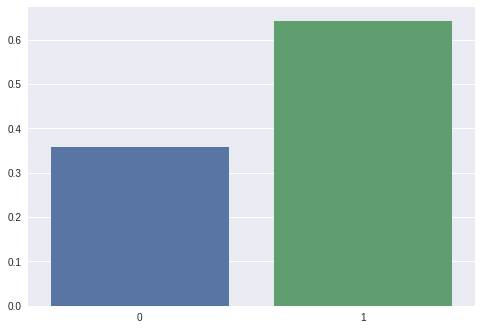

In [36]:
sns.barplot(x = stars, y = stars, estimator=lambda x: len(x)/len(stars))
plt.show()

## Generator function

In [18]:
# keras needs arrays as inputs, so .A reconverts a batch to the original numpy array

def get_batch(matrix, labels, bs):
    # matrix should be a document x word csr matrix
    i = 0
    while i < matrix.shape[0]/bs:
        yield matrix[i*bs:(i+1)*bs,].A, labels[i*bs:(i+1)*bs]
        i+=1  

In [19]:
generator = get_batch(matrix, stars, 32)

In [22]:
next(generator)

(array([[ 2.,  1.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([4, 4, 4, 5, 4, 5, 2, 3, 4, 3, 4, 3, 1, 1, 3, 4, 3, 5, 2, 2, 4, 4, 2,
        4, 3, 3, 5, 5, 1, 3, 3, 4]))

In [20]:
corpus[1]

[(22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]

In [4]:
??corpus2dense

In [31]:
a = ''
for word in reviews[3]:
    a += ' ' + word

In [40]:
len({word for review in reviews for word in review})

157720

In [22]:
review_lens = [len(review) for review in reviews]


In [23]:
print(np.max(review_lens))
print(np.min(review_lens))
print(np.std(review_lens))
print(np.median(review_lens))
print(np.mean(review_lens))
print(np.percentile(review_lens, 99.5))

818
0
49.4291317696
37.0
52.9195815112
294.0


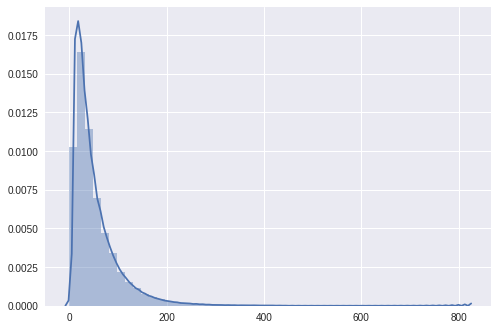

In [24]:
sns.distplot(review_lens)
plt.show()

In [75]:
# originally written to cut review lengths, did this in gensim_walkthrough instead
def cut(review, cutoff=30):
    text = ''
    for i, word in enumerate(review):
        if i <= 30:
            if text == '':
                text = word
            else:    
                text += ' ' + word
    return text        

In [20]:
vocab_size = len(dict_yelp.keys())

## Modeling 

In [39]:
import keras.backend as K
from keras.utils import to_categorical
from keras import models, optimizers, regularizers
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, GRU, Embedding

In [135]:
stars_cat = to_categorical(stars)[:,1:]

In [22]:
with open('ratings.npy', 'wb') as f:
    np.save(f, stars)


In [15]:
stars_cat[0:5]

array([1, 1, 1, 1, 1])

In [41]:
assert corpus.shape == (490049, 200)

In [40]:
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


In [56]:
??Conv2D

In [38]:
embedding_matrix.shape

(12580, 100)

In [39]:
??MaxPooling1D

In [49]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting
model = models.Sequential()
model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
model.add(Conv1D(100, 5))
model.add(Conv1D(100, 3))
model.add(MaxPooling1D(5))
model.add(LSTM(67))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1258000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 100)          50100     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 194, 100)          30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 67)                45024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 68        
Total params: 1,383,292
Trainable params: 1,383,292
Non-trainable params: 0
_________________________________________________________________


In [41]:
stars[0:10]

[3, 3, 3, 3, 3, 3, 1, 2, 3, 2]

In [177]:
a = matrix[0:10000].A

In [178]:
a.size * a.itemsize / 1024**2

57.220458984375

In [179]:
a.data.nbytes/1024**2

57.220458984375

In [150]:
np.matrix(corpus).shape

(490049, 300)

In [261]:
corpus = corpus.astype('float32')

## Training

In [52]:
model.fit(train, train_y, batch_size=32, epochs=2, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/2
313631/313631 [==============================] - 538s - loss: 0.4317 - acc: 0.8312 - val_loss: 0.4080 - val_acc: 0.8402
Epoch 2/2
313631/313631 [==============================] - 545s - loss: 0.3888 - acc: 0.8484 - val_loss: 0.4068 - val_acc: 0.8347


In [48]:
model.reset_states()

In [53]:
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [55]:
model.fit(train, train_y, batch_size=32, epochs=1, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/1
313631/313631 [==============================] - 531s - loss: 0.3579 - acc: 0.8621 - val_loss: 0.3760 - val_acc: 0.8519


In [ ]:
model.save('./models/lstm')

In [2]:
from keras.models import load_model
model = load_model('./models/test_ann')

In [59]:
model.metrics_names

['loss', 'acc']

In [57]:
model.evaluate(test, test_y, batch_size=32, verbose=1)

98010/98010 [==============================] - 41s    


[0.3730246889750552, 0.85426997246881875]

In [29]:
model.predict(corpus[5000:5050])

array([[ 0.14394325],
       [ 0.86664808],
       [ 0.56147665],
       [ 0.98652112],
       [ 0.84166902],
       [ 0.76998585],
       [ 0.99021286],
       [ 0.49010915],
       [ 0.00517744],
       [ 0.37810352],
       [ 0.266819  ],
       [ 0.79128629],
       [ 0.03544188],
       [ 0.98538059],
       [ 0.94302636],
       [ 0.80522889],
       [ 0.19055192],
       [ 0.09014103],
       [ 0.97314012],
       [ 0.02389133],
       [ 0.78602284],
       [ 0.49707806],
       [ 0.21730156],
       [ 0.41370717],
       [ 0.90246773],
       [ 0.01938556],
       [ 0.86966944],
       [ 0.80826139],
       [ 0.53455085],
       [ 0.0090926 ],
       [ 0.10485408],
       [ 0.14974253],
       [ 0.97041208],
       [ 0.2977078 ],
       [ 0.60295832],
       [ 0.1646433 ],
       [ 0.92289692],
       [ 0.0913669 ],
       [ 0.86934394],
       [ 0.8187418 ],
       [ 0.27017084],
       [ 0.67506003],
       [ 0.85775781],
       [ 0.86417305],
       [ 0.33068296],
       [ 0

In [69]:
matrix[14].A.sum()

11

In [145]:
help(model.train_on_batch)

Help on method train_on_batch in module keras.models:

train_on_batch(x, y, class_weight=None, sample_weight=None) method of keras.models.Sequential instance
    Single gradient update over one batch of samples.
    
    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        y: labels, as a Numpy array.
        class_weight: dictionary mapping classes to a weight value,
            used for scaling the loss function (during training only).
        sample_weight: sample weights, as a Numpy array.
    
    # Returns
        Scalar training loss (if the model has no metrics)
        or list of scalars (if the model computes other metrics).
        The attribute `model.metrics_names` will give you
        the display labels for the scalar outputs.
    
    # Raises
        RuntimeError: if the model was never compiled.

